# 支持向量机

**支持向量机 (Support Vector Machine)** 是一种监督学习算法，旨在找到一个最优超平面以最大化不同类别之间的数据间隔，提升泛化能力

### 超平面
**超平面方程**$wx + b = 0$ 其中$w$为**法向量**，b为**位移项**

例如，对一个输入特征数为2的数据集，其超平面为一条直线


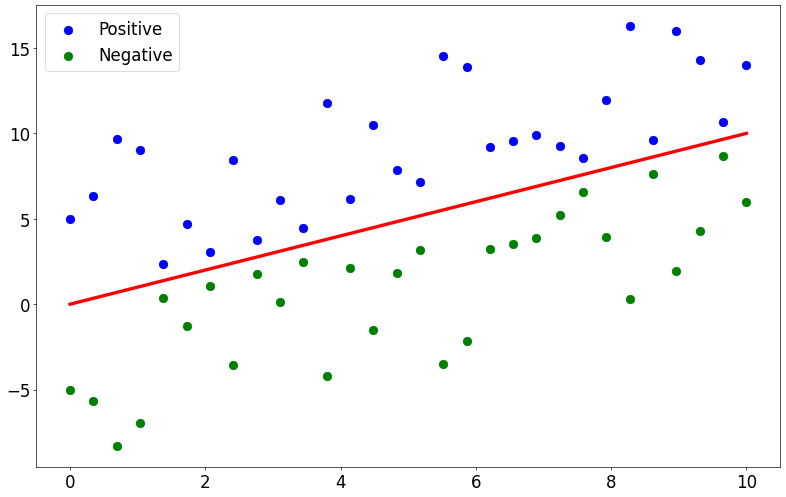

In [133]:
import matplotlib.pyplot as plt
import numpy as np

base = np.linspace(0, 10, 30)
noise = np.random.randint(1, 10, size=30)
positive = base + noise
negetive = base - noise

plt.figure(figsize=(16, 10), dpi=60)
plt.plot(base, base, color="Red", linewidth=4)
plt.scatter(base, positive, c="BLUE", label="Positive", s=100)
plt.scatter(base, negetive, c="GREEN", label="Negative", s=100)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(prop={"size": 20})
plt.show()

### 分类规则

$$
\begin{cases}
y_i = +1，\ \ wx_i + b \geq 1\\
y_i = -1，\ \ wx_i + b \leq 1\\
\end{cases}
\newline\space\newline
综合约束条件，y_i(wx_i+b) \geq 1
$$

当 $x_i$ 为**支持向量(Support Vector)**，即离最优超平面最近的样本点时 $y_i(wx_i+b)=1$

---

### 间隔计算
$$
r = \frac{|wx_i + b|}{||w||} = \frac{y_i(wx_i + b)}{||w||}
$$
当$x_i$为**支持向量**时，
$$
r = \frac{1}{||w||}
$$
两个不同类的支持向量到超平面的距离之和为
$$
\gamma = \frac{2}{||w||}
$$


## 求解最优超平面
### 法一 梯度下降

#### 损失函数
**合页损失函数**定义
$$
L(w, b) = \sum_{n}^{i=1} max(0, 1-y_i(wx_i+b))
\newline\space\newline
当分类正确且间隔 \geq 1，L(w, b) = 0
\newline\space\newline
当分类正确且间隔 < 1， L(w, b) = 1-y_i(wx_i + b)，损失随偏离程度线性增加
$$

### 目标函数
$$
J(w, b) = \frac{1}{2}||w||^2 + C\sum_{n}^{i=1} max(0, 1-y_i(wx_i+b))
$$
- 第一项 $\frac{1}{2}||w||^2$ 是正则化项，用于控制模型复杂度，防止过拟合
- 第二项 $C\sum_{n}^{i=1} max(0, 1-y_i(wx_i+b))$ 是惩罚项，其中$C$为正则化参数，平衡正则化项与损失项的重要性
 
### 计算梯度
对$w$求偏导：
- 对正则化项
$$
\nabla(\frac{1}{2}||w||^2) = w
$$
- 对损失项
$$
\begin{cases}
0, \ \ \ \ \  \ \ \ \ y_i(wx_i + b) \geq 1\\
-y_ix_i, \ \ y_i(wx_i + b) \\
\end{cases}
$$

- 则，总梯度为
$$
\nabla_w J(w, b) = w + C \sum_{i=1}^{n}
\begin{cases}
0, \ \ \ \ \  \ \ \ \ y_i(wx_i + b) \geq 1\\
-y_ix_i, \ \ y_i(wx_i + b) \\
\end{cases}
$$

同理，对b求偏导得
$$
\nabla_b J(w, b) = C \sum_{i=1}^{n}
\begin{cases}
0, \ \ \ \ \  \ \ \ \ y_i(wx_i + b) \geq 1\\
-y_i, \ \ y_i(wx_i + b) \\
\end{cases}
$$

#### 梯度下降的优缺点
- 优点：简单
- 缺点：无法使用核函数进行升维

#### **下面用代码实现**

In [134]:
import numpy as np

X = np.array([1, 3, 4, 5, 6]).reshape(-1, 1)
y = np.array([1, 1, 1, -1, -1])
coef = np.ones(1)
mask = (y * (X @ coef)) < 1
cri = y[mask] * (X[mask] @ coef)
loss = np.sum(cri)

print(cri)
print(loss)

[-5. -6.]
-11.0


In [135]:
import numpy as np
from sklearn.datasets import make_blobs

class SVM_binary:
    def __init__(self, epoches=100, learning_rate=0.01, C=1, bias: bool=True):
        self.epoches = epoches
        self.learning_rate = learning_rate
        self.C = C
        self._coef = None
        self.bias = bias


    def _init_coef(self, n_features):
        self._coef = np.zeros(n_features)


    def fit(self, X: np.ndarray, y: np.ndarray):

        if X.shape[0] != y.shape[0]:
            raise ValueError(f"X 与 y 的样本数量不匹配 X: {X.shape}, y: {y.shape}")

        if X.ndim == 1:
            X = X.reshape(-1, 1)

        y[y == 0] = -1


        if self.bias:
            X = np.column_stack((np.ones(X.shape[0]), X))

        n_samples, n_features = X.shape
        self._init_coef(n_features)

        for epoch in range(self.epoches):
            y_pred = X @ self._coef
            mask = y * (y_pred) < 1
            loss = np.sum(1 - y[mask] * (X[mask] @ self._coef))
            gradient = self._coef - self.C * np.sum(y[mask].reshape(-1, 1) * X[mask], axis=0)
            self._coef -= gradient * self.learning_rate


    def predict(self, X):
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        if self.bias:
            X = np.column_stack((np.ones(X.shape[0]), X))

        y_pred = X @ self._coef
        return y_pred

### 多分类实现

In [136]:
import numpy as np
from sklearn.datasets import make_blobs

class SVM:
    def __init__(self, epoches=100, learning_rate=0.01, C=1, bias: bool=True):
        self.epoches = epoches
        self.learning_rate = learning_rate
        self.C = C
        self.bias = bias
        self._coef = None
        self.classes = None
        self.classifiers: dict[any, SVM_binary] = {}


    def fit(self, X: np.ndarray, y: np.ndarray):
        self.classes = np.unique(y)

        for c in self.classes:
            y_binary = (y==c).astype(int)
            # print(y_binary)
            classifier = SVM_binary(epoches=self.epoches,
                                    learning_rate=self.learning_rate,
                                    C=self.C,
                                    bias=self.bias)

            # print(y_binary)
            classifier.fit(X, y_binary)
            self.classifiers[c] = classifier


    def predict(self, X):
        n_samples = X.shape[0]

        probabilitites = np.zeros(shape=(n_samples, len(self.classes)))

        for idx, c in enumerate(self.classes):
            probabilitites[:, idx] = self.classifiers[c].predict(X)

        # print(probabilitites)

        y_pred = np.argmax(probabilitites, axis=1)

        return y_pred

data = make_blobs(n_features=2, centers=4, random_state=42)
X, y = data[0], data[-1]
model = SVM(epoches=2000, C=5, learning_rate=0.05)
model.fit(X, y)
y_pred = model.predict(X)
# print(y)
# print(y_pred)
print(f"准确率 {np.mean(y==y_pred)}")


准确率 0.98


### 补充 绘制决策边界

[[-11.21599712  -9.28196066]
 [-11.12386763  -9.28196066]
 [-11.03173813  -9.28196066]
 ...
 [  6.93351389  11.86656431]
 [  7.02564338  11.86656431]
 [  7.11777288  11.86656431]]
None


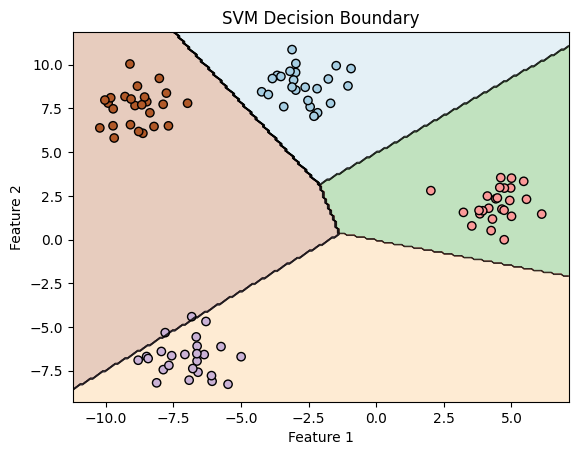

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 X 是二维特征数据，model 是训练好的 SVM 模型
# 定义网格的范围
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# 生成网格数据
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

print(grid)
print(model._coef)

# 预测每个网格点的类别
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

# 绘制决策边界
plt.contourf(xx, yy, Z, alpha=0.3, cmap="Paired")
# 绘制决策区域
plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

# 绘制样本点
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Paired", edgecolors='k')
plt.title("SVM Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
